# Introduction
<img src="flow.png" width="700">

In this tutorial we show how PartSeg API can be used to build composite processing pipelines in Python (see the overview of the pipeline in the figure). We show how to develop a browser base open-source Jupyter notebook for performing of segmentation of nuclei from 3-D images using PartSeg components as libraries. We describe how to automatically filter out properly segmented nuclei and later how to divide them based on presence/ absence of specific staining, into classes, which can be analysed separately.


## Motivation
Often biologist work on mixed population of cells, where subpopulations can be detected based on specific markers, like presence or absence of particular tags or proteins.

For quantitative measurements we want to process as many cases as possible. Yet, processing of hundreds of stacks and grouping them manually is laborious and otherwise could require hours of manual sorting of imaging data. Therefore automatic recognition of specific types of cells is necessary. This motivates collaboration between experimental biologists and bioinformaticians. Here we present how PartSeg components can be used as part of a larger application implemented in as Jupyter notebook. The pipeline allows to automatize quantitative analysis of different neuronal subtypes.

We argue that exposing the functionality of PartSeg in Python rather than designing a plugin or scripting module for PartSeg is preferable for bioinformaticians as Python is a general and well-known (low entry-cost) programming language with wealth of scientific libraries. At the same time keeping the UI simple and uncluttered is preferable for experimental biologists (again low entry-cost).


## Content

For the purpose of this tutorial in vitro culture of hippocampal neurons was fixed and subjected to fluorescent immunostaining with antibodies specific for two neuronal markers- Prox1 and CamKII. Later 3D images were acquired using Zeiss 780 confocal microscope, with voxel size 77x77x210 nm in xyz plains.

First channel of all images represent Prox1 staining, visible inside the nucleus and specific for subpopulation of excitatory neurons- granular neurons. Second channel shows CamKII enzyme present in the cell body (outside of the nucleus), which is characteristic for all excitatory neurons. Third and fourth channel represent DNA stained with Hoechst dye. The fourth channel is overexposed to facilitate segmentation of big nuclei containing less condensed, hence less visible DNA.

Data contains 4 types of cells :
1. Prox+, CamKII+ granular neurons (subtype of excitatory neurons).
2. Prox-, CamKII+ pyramidal neurons (subtype of excitatory neurons).
3. Prox-, CamKII- inhibitory neurons
4. Prox+, CamKII- not well characterized, immature neurons observed in in vitro culture.


## Remarks
1. We suggest to start from the tutorial showing basic functionalities of Partseg available [here](http://nucleus3d.cent.uw.edu.pl/PartSeg/tutorials/tutorial_chromosome_1/). In some parts few alternative options are shown.
2. Numbering of channels starts with 0.
3. Training data can be downloaded from [here](http://nucleus3d.cent.uw.edu.pl/PartSeg/Downloads/neuron_types.zip), Jupyter notebook is available [here](http://nucleus3d.cent.uw.edu.pl/PartSeg/tutorials/tutorial_diferrent_neurons/Neuron_types_example.ipynb)
4. Resulted code can be implemented into PartSeg body.
5. Every json file can be exported from PartSeg.

Data collection was carried out with the use of CePT infrastructure financed by the European Union - The European Regional Development Fund within the Operational Programme “Innovative economy” for 2007-2013.


## Base imports 

In [1]:
import os
import numpy as np 
from collections import defaultdict
import SimpleITK as sitk
from glob import glob 
from PartSegImage.image_reader import TiffImageReader 
from PartSegImage.image import Image
from math import pi

from PartSegCore.mask import load_metadata as load_mask_metadata
from PartSegCore.segmentation.segmentation_algorithm import ThresholdAlgorithm
from PartSegCore.mask.io_functions import load_stack_segmentation, save_components
from PartSegCore.analysis.measurement_calculation import Diameter, Volume
from PartSegCore.mask.algorithm_description import mask_algorithm_dict
from PartSegCore.convex_fill import convex_fill

from PartSegCore.analysis import load_metadata as load_analysis_metadata
from PartSegCore.analysis.algorithm_description import analysis_algorithm_dict
from PartSegCore.universal_const import Units

from matplotlib import pyplot as plt


# import PartSeg.plugins 
# PartSeg.plugins.register()  # Load PartSeg plugins

In [2]:
data_path = os.environ["DATA_PATH"]

## Prepare data
In this part there is shown how to read data and create or load segmentation

### Parameters of segmentaion 

Parameters  of segmentation can be read from file  

In [3]:
segmentation_description = load_mask_metadata(os.path.join(data_path, "segment_data.json"))
parameters1 = segmentation_description.values

or setted manually

In [4]:
from PartSegCore.segmentation.noise_filtering import DimensionType
parameters2 = {'channel': 3,
 'threshold': {'name': 'Manual', 'values': {'threshold': 19000}},
 'minimum_size': 8000,
 'close_holes': True,
 'close_holes_size': 200,
 'smooth_border': {"name": "None", "values": {}},
 'noise_filtering': {'name': 'Gauss',
 'values': {'dimension_type': DimensionType.Layer, 'radius': 1.0}},
 'side_connection': False,
 'use_convex': True}

### Read data

In [5]:
image = TiffImageReader.read_image(os.path.join(data_path, "DMSO_120min_2_4.lsm"))

### Calculate Segentation 

In [6]:
segment = ThresholdAlgorithm()
segment.set_image(image)
# Choose on of this line
segment.set_parameters(**parameters1)
segment.set_parameters(**parameters2)

In [7]:
# or 
Algorithm = mask_algorithm_dict[segmentation_description.algorithm]
segment = Algorithm()
segment.set_image(image)
# Choose on of this line
segment.set_parameters(**parameters1)
segment.set_parameters(**parameters2)

In [8]:
result = segment.calculation_run(print)
segmentation = result.segmentation

Noise removal 0
Threshold calculation 1
Threshold calculated 2
Filing holes 3
Smooth border 4
Components calculating 5
convex hull 6
Calculation done 7


## Load segmentaion

In [9]:
segmentation, metadata = load_stack_segmentation(os.path.join(data_path, "DMSO_120min_2_4.seg"))

## Veriffy segmentaion 
In example stack DMSO_120min_2_4.lsm on standard parameters, there are two cases that should be filtered. 
1. Three nucleus that are too close and are segmented as one component (number 1)
2. Nucleus that touch border of image (numbers 10, 11, 12)

When calculating sphericity (proportion between volume and volume of sphere with same diameter like component.
Threshold used in this step should depend on data. There are cell types with really irregular shapes 

In [10]:
good_neurons = []
for component_number in range(1, segmentation.max() + 1):
    current_component_area = segmentation == component_number
    # checking if touch borders 
    coords = np.nonzero(current_component_area)
    if 0 == np.min(coords):
        continue
    touch = False
    for axis_cords, max_size in zip(coords, current_component_area.shape):
        if np.max(axis_cords) == max_size - 1:
            touch = True
            break
    if touch:
        continue
    diameter = Diameter.calculate_property(current_component_area, voxel_size=image.spacing, result_scalar=10**6)
    volume = Volume.calculate_property(current_component_area, voxel_size=image.spacing, result_scalar=10**6)
    # calculate shericity
    # print(component_number, (4/3 * pi * (diameter/2)**3)/volume, diameter)
    if (4/3 * pi * (diameter/2)**3)/volume > 4:
        continue 
    good_neurons.append(component_number)
print(good_neurons)

[2, 3, 4, 5, 6, 7, 8, 9]


# Classify neurons
There are three types of neurons:
1. granular - with red markers inside and green marker near surface
2. pyramidal - with green marker near surface, but without red marker
3. inhibitory - without both markers

**In code channels are numbered from 0**

In [11]:
neuron_type_dict = defaultdict(list)
good_neurons = set(good_neurons)
for component_number in range(1, segmentation.max() + 1):
    if component_number not in good_neurons:
        continue
    current_component_area = segmentation == component_number
    value_red = np.percentile(image.get_channel(0)[0][current_component_area], 75)
    # radius is 3, 9, 9 because voxel size is 210x70x70nm and voxel size is in pixels, not physicla units
    dilate_sitk = sitk.BinaryContour(sitk.GetImageFromArray(current_component_area.astype(np.uint8)))
    dilate_mask = sitk.GetArrayFromImage(sitk.BinaryDilate(dilate_sitk, (3, 9 ,9)))
    # dilate_mask = dilate(current_component_area, (3, 9 ,9), False) # slower than two above lines but combined witrh next gave same result
    dilate_mask[current_component_area] = 0
    value_green = np.percentile(image.get_channel(1)[0][current_component_area], 75)
    # print(component_number, value_red, value_green)
    if value_red > 7000:
        if value_green > 7000:
            neuron_type_dict["granular"].append(component_number)
            continue
        else:
            neuron_type_dict["unexpected"].append(component_number)
            continue
    elif value_green > 7000:
        neuron_type_dict["pyramidal"].append(component_number)
        continue
    neuron_type_dict["inhibitory"].append(component_number)
print(neuron_type_dict)
    
    

defaultdict(<class 'list'>, {'pyramidal': [2], 'inhibitory': [3, 4, 9], 'granular': [5, 6, 7, 8]})


### Save cutted nucleus 

In [12]:
save_path = os.path.join(data_path, "DMSO_120min_2_1")
for key, value in neuron_type_dict.items():
    dir_path = os.path.join(save_path, key)
    os.makedirs(dir_path, exist_ok=True)
    save_components(image, value, segmentation, dir_path)

### Extract nucleus from stack

In [13]:
nucleus_dict = defaultdict(list)
for neuron_type, compenents_list in neuron_type_dict.items():
    for component_number in compenents_list:
        im = image.cut_image(segmentation == component_number, replace_mask=True)
        nucleus_dict[neuron_type].append((component_number, im))

### Pack whole segmentation in function

In [14]:
def get_good_neurons(image: Image, segmentation: np.ndarray):
    good_neurons = []
    for component_number in range(1, segmentation.max() + 1):
        current_component_area = segmentation == component_number
        # checking if touch borders 
        coords = np.nonzero(current_component_area)
        if 0 == np.min(coords):
            continue
        touch = False
        for axis_cords, max_size in zip(coords, current_component_area.shape):
            if np.max(axis_cords) == max_size - 1:
                touch = True
                break
        if touch:
            continue
        diameter = Diameter.calculate_property(current_component_area, voxel_size=image.spacing, result_scalar=1)
        volume = Volume.calculate_property(current_component_area, voxel_size=image.spacing, result_scalar=1)
        # calculate
        # print(component_number, (4/3 * pi * (diameter/2)**3)/volume, diameter)
        if (4/3 * pi * (diameter/2)**3)/volume > 4.5:
            continue 
        good_neurons.append(component_number)
    print(f"filtered {segmentation.max() - len(good_neurons)}")
    return set(good_neurons)

def classify_neurons(image: Image, segmentation: np.ndarray, good_neurons: set):
    neuron_type_dict = defaultdict(list)
    for component_number in range(1, segmentation.max() + 1):
        if component_number not in good_neurons:
            continue
        current_component_area = segmentation == component_number
        value_red = np.percentile(image.get_channel(0)[0][current_component_area], 75)
        # radius is 3, 9, 9 because voxel size is 210x70x70nm and voxel size is in pixels, not physicla units
        dilate_sitk = sitk.BinaryContour(sitk.GetImageFromArray(current_component_area.astype(np.uint8)))
        dilate_mask = sitk.GetArrayFromImage(sitk.BinaryDilate(dilate_sitk, (3, 9 ,9)))
        # dilate_mask = dilate(current_component_area, (3, 9 ,9), False) # slower than two above lines but combined witrh next gave same result
        dilate_mask[current_component_area] = 0
        value_green = np.percentile(image.get_channel(1)[0][current_component_area], 75)
        # print(component_number, value_red, value_green, np.percentile(image.get_channel(1)[current_component_area], 50))
        if value_red > 7000:
            if value_green > 7000:
                neuron_type_dict["granular"].append(component_number)
                continue
            else:
                neuron_type_dict["unexpected"].append(component_number)
                continue
        elif value_green > 7000:
            neuron_type_dict["pyramidal"].append(component_number)
            continue
        neuron_type_dict["inhibitory"].append(component_number)
    if "unexpected" in neuron_type_dict:
        items = len(neuron_type_dict['unexpected'])
        print(f"deleted {items} neurons {neuron_type_dict['unexpected']}")
        del neuron_type_dict["unexpected"]
    # print(neuron_type_dict)
    return neuron_type_dict
    
def segmentation_function(path_to_file, segment_object):
    def empty(_x, _y):
        pass
    image = TiffImageReader.read_image(path_to_file)
    segment_object.set_image(image)
    result = segment_object.calculation_run(empty)
    segmentation = result.segmentation
    
    good_neurons = get_good_neurons(image, segmentation)
    segmentation = convex_fill(segmentation)
    classified_neurons = classify_neurons(image, segmentation, good_neurons)
    
    nucleus_dict = defaultdict(list)
    for neuron_type, compenents_list in classified_neurons.items():
        for component_number in compenents_list:
            im = image.cut_image(segmentation == component_number, replace_mask=True)
            nucleus_dict[neuron_type].append((component_number, im))
    return nucleus_dict

In [15]:
segmentation_description = load_mask_metadata(os.path.join(data_path, "segment_data.json"))
parameters = segmentation_description.values
# this change is done to better filter components which contains few nucleus
# then I calculate convex hull inside segmentation_function
parameters["use_convex"] = False
Algorithm = mask_algorithm_dict[segmentation_description.algorithm]
segment = Algorithm()
segment.set_parameters(**parameters)

cutted_neurons_dict = dict()

for file_path in glob(os.path.join(data_path, "*.lsm")):
    print("proces", os.path.basename(file_path))
    cutted_neurons_dict[file_path] = segmentation_function(file_path, segment)
    


proces DMSO_120min_2_2.lsm
filtered 1
proces DMSO_120min_2_3.lsm
filtered 2
proces DMSO_120min_2_5.lsm
filtered 0
deleted 1 neurons [1]
proces DMSO_120min_2_1.lsm
filtered 0
proces DMSO_120min_2_4.lsm
filtered 4


### Setup inside neuron segmentation algorithm
It can be set manually like in stack segmentation

In [16]:
neuron_segmentation_description = load_analysis_metadata(os.path.join(data_path, "neuron_types_segmentation.json"))

neuron_segmentation_profile = neuron_segmentation_description["neuron_types"]
NeuronAlgoritm = analysis_algorithm_dict[neuron_segmentation_profile.algorithm]
neuron_segment = NeuronAlgoritm()
neuron_segment.set_parameters(**neuron_segmentation_profile.values)

### Setup measurment
It can be set manually using classes from `PartSegCore..analysis.measurement_calculation`

In [17]:
neuron_measurment_description = load_analysis_metadata(os.path.join(data_path, "neuron_types_measurment.json"))
    
print(str(neuron_measurment_description["neuron_types"]))
measurment_object = neuron_measurment_description["neuron_types"]

Set name: neuron_types
Measurements list:
Mask Volume
Segmentation Volume/Mask Volume



In [18]:
def empty(_x, _y):
    pass
measurment_dict = defaultdict(list)
for file_path, nucleus_group_dict in cutted_neurons_dict.items():
    for nucleus_type, nucleus_list in nucleus_group_dict.items():
        for _, nucleus in nucleus_list:
            neuron_segment.set_image(nucleus)
            neuron_segment.set_mask(nucleus.mask[0])  # do not touch time 
            neuron_segment.set_parameters(**neuron_segmentation_profile.values)
            result = neuron_segment.calculation_run(empty)
            measurment_dict[nucleus_type].append(
                measurment_object.calculate(nucleus.get_channel(2), result.segmentation, result.full_segmentation,
                                            nucleus.mask[0], nucleus.spacing, Units.nm))
            

In [19]:
measurment_result = []
for neuron_type, values in measurment_dict.items():
    sub_result = defaultdict(list)
    for value_dict in values:
        for key, (value, _) in value_dict.items():
            sub_result[key].append(value)
    measurment_result.append((neuron_type, [(name, np.mean(v), np.std(v)) for name, v in sub_result.items()]))

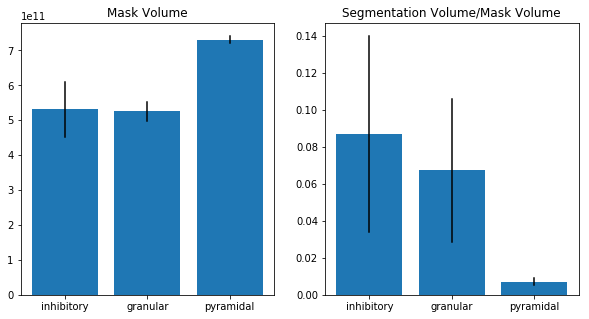

In [20]:
ticks, values = list(zip(*measurment_result))
values = list(zip(*values))
f, axx = plt.subplots(1, len(values), figsize=(5 * len(values),5))
for el, ax in zip(values, axx):
    name, mean, std = list(zip(*el))
    plt.sca(ax)
    plt.title(name[0])
    plt.bar(range(len(ticks)), mean)
    for i, m, s in zip(range(len(mean)), mean, std):
        plt.plot([i, i], [m - s/2, m + s/2], color="black")
    plt.xticks(range(len(ticks)), ticks)

# Appendix

## How preview result in notebook

In this part I show show preview result of segmentation in notebook using matplotlib. It can be also done with k3d.

In [21]:
from matplotlib import pyplot as plt 
# %matplotlib notebook


In [22]:
from PartSegCore.color_image import color_image_fun, add_labels 

In [23]:
image_app = TiffImageReader.read_image(os.path.join(data_path, "DMSO_120min_2_1.lsm"))
segmentation_app, metadata_app = load_stack_segmentation(os.path.join(data_path, "DMSO_120min_2_1.seg"))

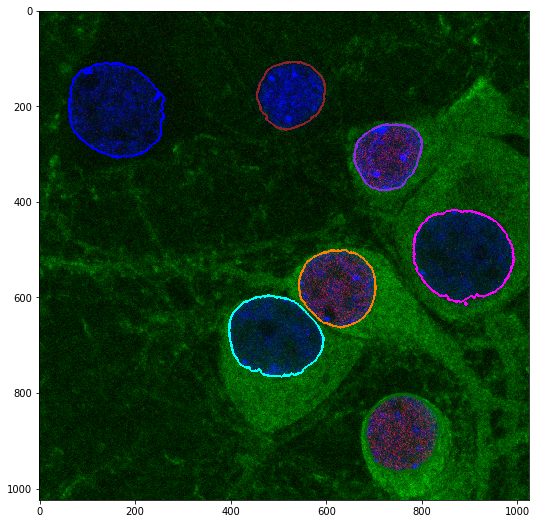

In [24]:
from PartSegCore.color_image import default_colormap_dict
layer_num = 28
layer = image_app.get_layer(0, layer_num)
components_to_show = np.ones(segmentation_app.max()+1, dtype=np.uint8)
colormaps_list = [default_colormap_dict.get(x, None) for x in ["BlackRed", "BlackGreen", "BlackBlue", None]]
colored_image = color_image_fun(layer, colors=colormaps_list, min_max=image_app.get_ranges())
add_labels(colored_image, segmentation_app[layer_num], 1, True, 2, components_to_show)
plt.figure(figsize=(9, 9))
plt.imshow(colored_image)
plt.show()
# plt.imshow(result.segmentation[layer_num])

optional with interactive layer change 

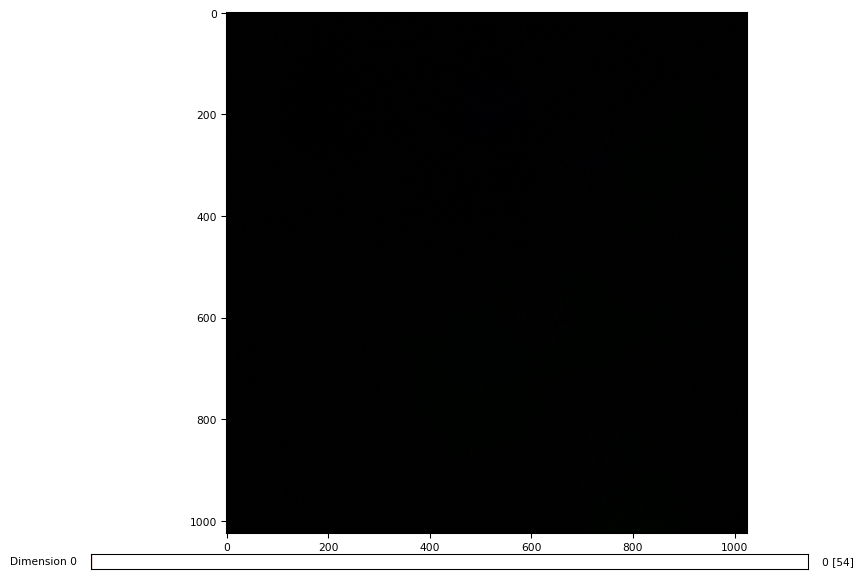

In [25]:
import tifffile
from PartSegCore.color_image import default_colormap_dict
colormaps_list = [default_colormap_dict.get(x, None) for x in ["BlackRed", "BlackGreen", "BlackBlue", None]]
colored_stack = []
for i in range(image_app.layers):
    layer = image_app.get_layer(0, i)
    colored_image = color_image_fun(layer, colors=colormaps_list, min_max=image_app.get_ranges())
    add_labels(colored_image, segmentation_app[i], 1, True, 2, components_to_show)
    colored_stack.append(colored_image)
colored_array = np.stack(colored_stack)
tifffile.imshow(colored_array)
plt.show()


## Save stack segmentation

how to save segmentation result to easy preview in PartSeg mask

In [26]:
import os 
from glob import glob 

from PartSegCore.mask.io_functions import SaveSegmentation, SegmentationTuple
from PartSegCore.segmentation.segmentation_algorithm import ThresholdAlgorithm
from PartSegImage.image_reader import TiffImageReader


In [27]:
for file_path in glob(os.path.join(data_path, "*.lsm")):
    print("proces", os.path.basename(file_path))
    segment = ThresholdAlgorithm()
    segment.set_parameters(**parameters)
    image = TiffImageReader.read_image(file_path)
    segment.set_image(image)
    result = segment.calculation_run(empty)
    segmentation = result.segmentation
    seg_tup = SegmentationTuple(image.file_path, image, segmentation, [])
    save_path = os.path.splitext(file_path)[0] + ".seg"
    SaveSegmentation.save(save_path, seg_tup, {"relative_path": True})

proces DMSO_120min_2_2.lsm
proces DMSO_120min_2_3.lsm
proces DMSO_120min_2_5.lsm
proces DMSO_120min_2_1.lsm
proces DMSO_120min_2_4.lsm
